In [22]:
import metrics2 as metrics
import dspy
import os
import yaml
import json
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import random
import examples

with open(os.path.join("..", "keys.yaml"), "r") as file:
    config = yaml.safe_load(file)
    openai_api_key = config["openai_api_key"]
    
grader = dspy.OpenAI(
            model="gpt-4o",
            model_type="chat",
            max_tokens=2000,
            api_key=openai_api_key,
        )
    
max_score = metrics.MAX_SCORE

In [23]:
empty_input = dspy.Example()

# Test 1: Conciseness

In [24]:
short_output = dspy.Prediction(narrative='word ')
short_result = metrics.conciseness(empty_input, short_output, max_optimal_length=10)
assert short_result == max_score, short_result

long_output = dspy.Prediction(narrative='word ' * 21)
long_result = metrics.conciseness(empty_input, long_output, max_optimal_length=10)
assert long_result == 0, long_result

med_output = dspy.Prediction(narrative='word ' * 15)
med_result = metrics.conciseness(empty_input, med_output, max_optimal_length=10)
assert med_result == max_score / 2, med_result

# Test 2: Accuracy

In [25]:
test_input = dspy.Example(explanation='(Size, 5, 10), (Color, Red, -8)', 
                          explanation_format='(feature_name, feature_value, SHAP contribution)')

accurate_output = dspy.Prediction(narrative='The size being 5 increased the prediction by 10. The color being red decreased the prediction by 8.')
accurate_result = metrics.accuracy(test_input, accurate_output, grader=grader)
assert accurate_result == max_score, accurate_result

inaccurate_output = dspy.Prediction(narrative='The size being 4 increased the prediction by 11. The color being red decreased the prediction by 9.')
inaccurate_result = metrics.accuracy(test_input, inaccurate_output, grader=grader)
assert inaccurate_result == 0, inaccurate_result

incomplete_but_accurate_output = dspy.Prediction(narrative='The size being 5 increased the prediction by 10.')
incomplete_but_accurate_result = metrics.accuracy(test_input, incomplete_but_accurate_output, grader=grader)
assert incomplete_but_accurate_result == max_score, incomplete_but_accurate_result

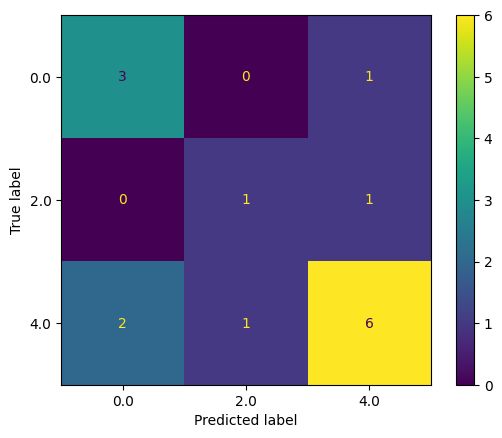

In [26]:
accuracy_dataset = json.load(open("accuracy_tests.json"))

preds = []
actuals = []
for example in accuracy_dataset:
    test_input = dspy.Example(explanation=example["explanation"], explanation_format=example["explanation_format"])
    test_output = dspy.Prediction(narrative=example["narrative"])
    result = metrics.accuracy(test_input, test_output, grader)
    preds.append(result)
    actuals.append(example["accuracy_score"])

cm = confusion_matrix(actuals, preds, labels=[0.0, 2.0, 4.0])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0.0, 2.0, 4.0])
disp.plot()

# Test 3: Completeness

In [27]:
test_input = dspy.Example(explanation='(Size, 5, 10), (Color, Red, -8), (Shape, Square, 3)', 
                          explanation_format='(feature_name, feature_value, SHAP contribution)')

complete_output = dspy.Prediction(narrative='The size being 5 increased the prediction by 10. The color being red decreased the prediction by 8. The shape being square increased the prediction by 3.')
complete_result = metrics.completeness(test_input, complete_output, grader)
assert complete_result == max_score, complete_result

incomplete_output = dspy.Prediction(narrative='The size being 5 increased the prediction by 10. The color being red decreased the prediction by 8.')
incomplete_result = metrics.completeness(test_input, incomplete_output, grader)
assert incomplete_result == 0, incomplete_result

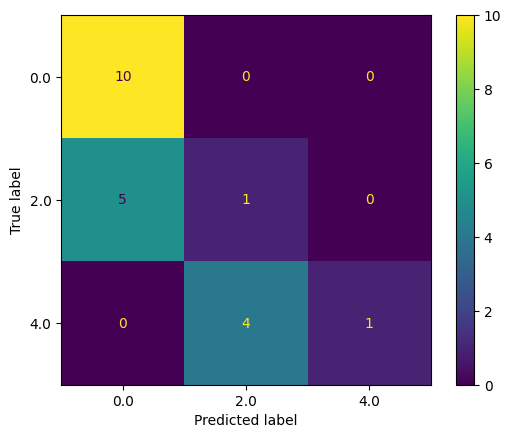

In [28]:
completeness_dataset = json.load(open("completeness_tests.json"))

preds = []
actuals = []
for example in completeness_dataset:
    test_input = dspy.Example(explanation=example["explanation"], explanation_format=example["explanation_format"])
    test_output = dspy.Prediction(narrative=example["narrative"])
    result = metrics.completeness(test_input, test_output, grader)
    preds.append(result)
    actuals.append(example["completeness_score"])

cm = confusion_matrix(actuals, preds, labels=[0.0, 2.0, 4.0])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0.0, 2.0, 4.0])
disp.plot()

# Test 4: Fluency

We test fluency with two methods:
1. A few basic unit tests
2. Ensuring that fluency consistently scores higher on whatever dataset is labeled gold standard dataset than on other datasets

In [29]:
good_narratives = ['The large size increased the prediction by 100, while the green color decreased it by about 20',
                   "The item's small size of 2 decreased the prediction by about 4, while its blue color increased it by 3"]

fluent_output = dspy.Prediction(narrative='The large size of the item increased the prediction by about 10, while the red color decreased it by 8.')
fluent_result = metrics.fluency(empty_input, fluent_output, grader, good_narratives=good_narratives)

influent_output = dspy.Prediction(narrative='The size being 5 increased the prediction by 10.5. The color being red decreased it by 8.2')
influent_result = metrics.fluency(empty_input, influent_output, grader, good_narratives=good_narratives)

assert influent_result < fluent_result
assert fluent_result == max_score, fluent_result

very_influent_output = dspy.Prediction(narrative='Size 5 10.5 color red')
very_influent_result = metrics.fluency(empty_input, very_influent_output, grader, good_narratives=good_narratives)
assert very_influent_result == 0, very_influent_result

In [ ]:
metric_verification_datasets = ["gold_standards.json", "unaligned_examples_1.json", "unaligned_examples_2.json"]

labeled_train, labeled_eval, unlabeled_train, unlabeled_eval = examples.get_data("gold_standards.json")
train_data = labeled_train + unlabeled_train
eval_data = labeled_eval + unlabeled_eval
max_optimal_length = max([len(d.narrative) for d in labeled_train])

example_good_narratives = random.sample([d.narrative for d in labeled_train], 5)
example_bad_narratives = random.sample([d.bad_narrative for d in labeled_train if hasattr(d, "bad_narrative")], 5)

# Example datasets do not include a rationalization, so we skip context awareness 
ver_metrics = metrics.Metrics(
    [
        metrics.accuracy,
        metrics.fluency,
        metrics.conciseness,
        #metrics.completeness
    ], verbose=0, openai_key=openai_api_key,
    metric_kwargs={"conciseness": {"max_optimal_length": max_optimal_length},
                   "fluency": {"good_narratives": example_good_narratives, "bad_narratives": example_bad_narratives}}
)

for dataset in metric_verification_datasets: 
    labeled_train, _, _, _ = examples.get_data(dataset, split=1)
    all_results = None
    score = 0
    for example in labeled_train:
        result = ver_metrics(example, example)
        score += result[0]
        if all_results is None:
            all_results = result[1]
        else:
            all_results += result[1]
    print(f"Dataset: {dataset}, Average score: {score/len(labeled_train)}/{len(ver_metrics.metric_funcs)*4.0}")
    print(all_results/len(labeled_train))

# Test 5: Context-Awareness

In [ ]:
test_input = dspy.Example(explanation='(Size, 5, 10), (Color, Red, -8)', explanation_format='(feature_name, feature_value, SHAP contribution)')

context_aware_output = dspy.Prediction(narrative = 'The large size of 5 increased the price by 10. The red color decreased the price by 8.',
                                       rationalization='Large items fit more contents, making them desirable, so they increase the price. People associate red with the devil, so this color decreases the price.')
context_aware_result = metrics.context_awareness(test_input, context_aware_output, grader)
assert context_aware_result >= max_score/2, context_aware_result

context_unaware_output = dspy.Prediction(narrative = 'The large size of 5 increased the price by 10. The red color decreased the price by 8.', 
                                         rationalization='No idea why.')
context_unaware_result = metrics.context_awareness(test_input, context_unaware_output, grader)
assert context_unaware_result == 0, context_unaware_result

# Compare Datasets

In the following code block, we verify our metric functionality by comparing average score on our gold standard dataset (used to tune the metrics) to other datasets that use different styles of explanations. We expect the gold standard average score to be very close to 2*len(metrics) (since each metric is scored on a scale of 0-2), and the other datasets to be lower.
 
TODO: We do not currently verify the context awareness metric, as the gold-standard dataset does not include a rationalization

In [ ]:
metric_verification_datasets = ["gold_standards.json", "unaligned_examples_1.json", "unaligned_examples_2.json"]

labeled_train, labeled_eval, unlabeled_train, unlabeled_eval = examples.get_data("gold_standards.json")
train_data = labeled_train + unlabeled_train
eval_data = labeled_eval + unlabeled_eval
max_optimal_length = max([len(d.narrative) for d in labeled_train])

example_good_narratives = random.sample([d.narrative for d in labeled_train], 5)
example_bad_narratives = random.sample([d.bad_narrative for d in labeled_train if hasattr(d, "bad_narrative")], 5)

# Example datasets do not include a rationalization, so we skip context awareness 
ver_metrics = metrics.Metrics(
    [
        metrics.accuracy,
        metrics.fluency,
        metrics.conciseness,
        #metrics.completeness
    ], verbose=0, openai_key=openai_api_key,
    metric_kwargs={"conciseness": {"max_optimal_length": max_optimal_length},
                   "fluency": {"good_narratives": example_good_narratives, "bad_narratives": example_bad_narratives}}
)

for dataset in metric_verification_datasets: 
    labeled_train, _, _, _ = examples.get_data(dataset, split=1)
    all_results = None
    score = 0
    for example in labeled_train:
        result = ver_metrics(example, example)
        score += result[0]
        if all_results is None:
            all_results = result[1]
        else:
            all_results += result[1]
    print(f"Dataset: {dataset}, Average score: {score/len(labeled_train)}/{len(ver_metrics.metric_funcs)*4.0}")
    print(all_results/len(labeled_train))

# Failing Cases

In [ ]:
inaccurate_output = dspy.Prediction(narrative='The size being 5 decreased the prediction by 10. The color being red decreased the prediction by 8.')
inaccurate_result = metrics.accuracy(test_input, inaccurate_output, grader=grader)
assert inaccurate_result == 0, inaccurate_result

misleading_output = dspy.Prediction(narrative='Surprisingly, the large house size of 5 increased the predicted price')
misleading_result = metrics.accuracy(test_input, misleading_output, grader=grader)
assert 0 < misleading_result < 4, misleading_result